# A tour of PyCIEMSS interfaces and functionality

### Load dependencies and interfaces

In [1]:
import os
import pyciemss
import torch
import pandas as pd
import numpy as np
from typing import Dict, List

import pyciemss.visuals.plots as plots
import pyciemss.visuals.vega as vega
import pyciemss.visuals.trajectories as trajectories

from pyciemss.integration_utils.intervention_builder import (
    param_value_objective,
    start_time_objective,
)

smoke_test = ('CI' in os.environ)

/Users/altu809/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


### Select models and data

In [2]:
MODEL_PATH = "https://raw.githubusercontent.com/DARPA-ASKEM/simulation-integration/main/data/models/"
DATA_PATH = "https://raw.githubusercontent.com/DARPA-ASKEM/simulation-integration/main/data/datasets/"

model1 = os.path.join(MODEL_PATH, "SEIRHD_NPI_Type1_petrinet.json")
model2 = os.path.join(MODEL_PATH, "SEIRHD_NPI_Type2_petrinet.json")
model3 = os.path.join(MODEL_PATH, "SIR_stockflow.json")

dataset1 = os.path.join(DATA_PATH, "SIR_data_case_hosp.csv")
dataset2 = os.path.join(DATA_PATH, "traditional.csv")

### Set parameters for sampling

In [3]:
start_time = 0.0
end_time = 100.0
logging_step_size = 10.0
num_samples = 3 if smoke_test else 10

## Sample interface
Take `num_samples` number of samples from the (prior) distribution invoked by the chosen model.

### Sample from model 1

,timepoint_id,sample_id,timepoint_unknown,persistent_beta_c_param,persistent_kappa_param,persistent_gamma_param,persistent_hosp_param,persistent_death_hosp_param,persistent_I0_param,D_state,E_state,H_state,I_state,R_state,S_state,infected_observable_state,exposed_observable_state,hospitalized_observable_state,dead_observable_state
0,0,0,10.0,0.38329,0.789344,0.122211,0.070069,0.061244,14.045957,0.190017,4.080822e+02,4.843965,2.650393e+02,1.083762e+02,19339258.0,2.650393e+02,4.080822e+02,4.843965,0.190017
1,1,0,20.0,0.38329,0.789344,0.122211,0.070069,0.061244,14.045957,3.121283,5.640714e+03,67.824097,3.664649e+03,1.624359e+03,19329062.0,3.664649e+03,5.640714e+03,67.824097,3.121283
2,2,0,30.0,0.38329,0.789344,0.122211,0.070069,0.061244,14.045957,43.643059,7.740020e+04,935.375427,5.044738e+04,2.254029e+04,19188678.0,5.044738e+04,7.740020e+04,935.375427,43.643059
3,3,0,40.0,0.38329,0.789344,0.122211,0.070069,0.061244,14.045957,591.959106,9.624458e+05,12421.953125,6.548661e+05,3.022100e+05,17407508.0,6.548661e+05,9.624458e+05,12421.953125,591.959106
4,4,0,50.0,0.38329,0.789344,0.122211,0.070069,0.061244,14.045957,6531.081543,4.635214e+06,111681.515625,4.757070e+06,2.997585e+06,6831960.0,4.757070e+06,4.635214e+06,111681.515625,6531.081543


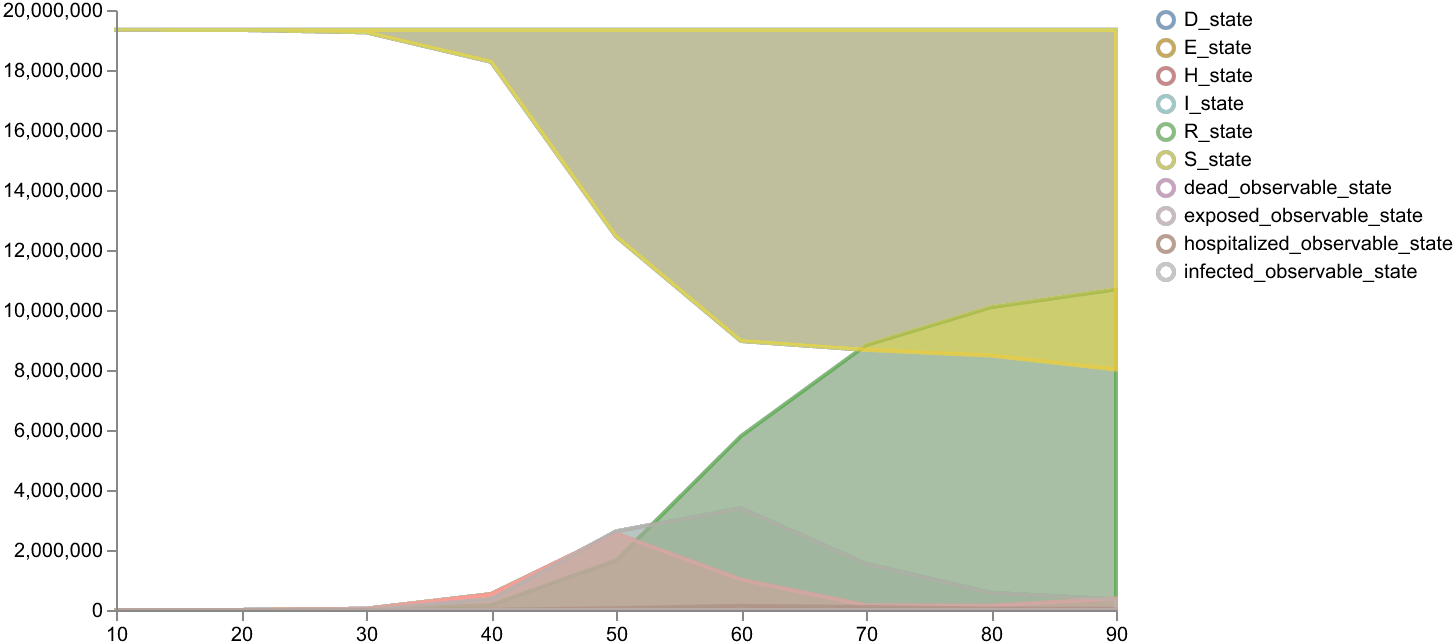

In [4]:
result1 = pyciemss.sample(model1, end_time, logging_step_size, num_samples, start_time=start_time)
display(result1['data'].head())

# Plot results for all states
schema = plots.trajectories(result1["data"], keep=".*_state")
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

### Sample from model 2

,timepoint_id,sample_id,timepoint_unknown,persistent_beta_c_param,persistent_beta_nc_param,persistent_kappa_param,persistent_gamma_param,persistent_hosp_param,persistent_death_hosp_param,persistent_I0_param,D_state,E_state,H_state,I_state,R_state,S_state,infected_observable_state,exposed_observable_state,hospitalized_observable_state,dead_observable_state
0,0,0,10.0,0.333225,0.276114,0.737392,0.46917,0.162994,0.023929,9.978355,0.210019,76.661270,8.716355,34.672840,98.397324,19339824.0,34.672840,76.661270,8.716355,0.210019
1,1,0,20.0,0.333225,0.276114,0.737392,0.46917,0.162994,0.023929,9.978355,0.896394,176.743073,21.475992,79.945152,339.215454,19339422.0,79.945152,176.743073,21.475992,0.896394
2,2,0,30.0,0.333225,0.276114,0.737392,0.46917,0.162994,0.023929,9.978355,2.507421,407.465149,49.699741,184.309372,895.593567,19338498.0,184.309372,407.465149,49.699741,2.507421
3,3,0,40.0,0.333225,0.276114,0.737392,0.46917,0.162994,0.023929,9.978355,6.225309,939.220947,114.595718,424.855316,2178.367432,19336380.0,424.855316,939.220947,114.595718,6.225309
4,4,0,50.0,0.333225,0.276114,0.737392,0.46917,0.162994,0.023929,9.978355,14.795435,2164.121826,264.109009,979.022949,5134.885742,19331480.0,979.022949,2164.121826,264.109009,14.795435


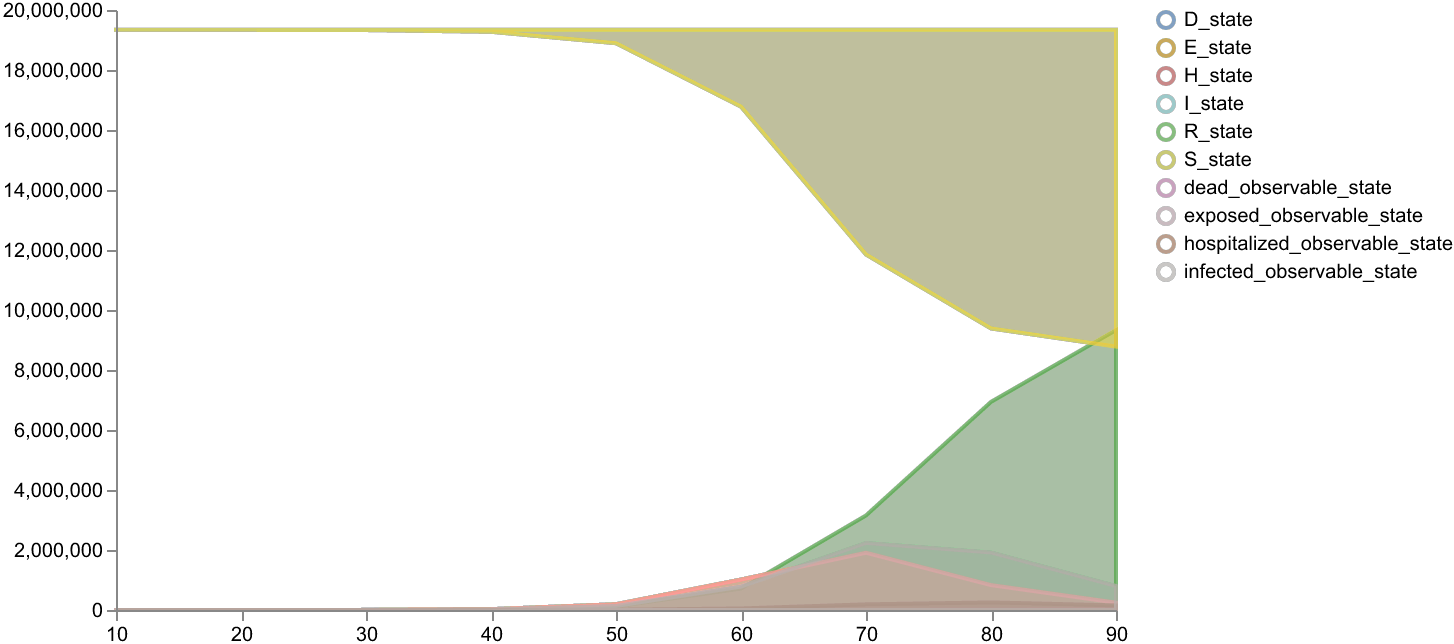

In [5]:
result2 = pyciemss.sample(model2, end_time, logging_step_size, num_samples, start_time=start_time)
display(result2['data'].head())

# Plot the result
schema = plots.trajectories(pd.DataFrame(result2["data"]), keep=".*_state")
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

## Ensemble Sample Interface
Sample from an ensemble of model 1 and model 2 

,timepoint_id,sample_id,timepoint_unknown,model_0/weight_param,model_1/weight_param,model_0/persistent_beta_c_param,model_0/persistent_kappa_param,model_0/persistent_gamma_param,model_0/persistent_hosp_param,model_0/persistent_death_hosp_param,...,D_state,E_state,H_state,I_state,R_state,S_state,infected_state,exposed_state,hospitalized_state,dead_state
0,0,0,10.0,0.523025,0.476975,0.681874,0.698013,0.161504,0.104895,0.029745,...,0.187784,145.057648,5.577466,100.437042,74.716782,19339708.0,100.437042,145.057648,5.577466,0.187784
1,1,0,20.0,0.523025,0.476975,0.681874,0.698013,0.161504,0.104895,0.029745,...,1.175356,1161.710571,33.653469,776.716187,580.021301,19337488.0,776.716187,1161.710571,33.653469,1.175356
2,2,0,30.0,0.523025,0.476975,0.681874,0.698013,0.161504,0.104895,0.029745,...,7.950854,9813.287109,269.319366,6537.526855,4706.126953,19318700.0,6537.526855,9813.287109,269.319366,7.950854
3,3,0,40.0,0.523025,0.476975,0.681874,0.698013,0.161504,0.104895,0.029745,...,63.743084,82028.859375,2261.181641,54999.269531,39482.000000,19161200.0,54999.269531,82028.859375,2261.181641,63.743084
4,4,0,50.0,0.523025,0.476975,0.681874,0.698013,0.161504,0.104895,0.029745,...,520.534912,598907.375000,18036.314453,424595.312500,320000.437500,17977966.0,424595.312500,598907.375000,18036.314453,520.534912


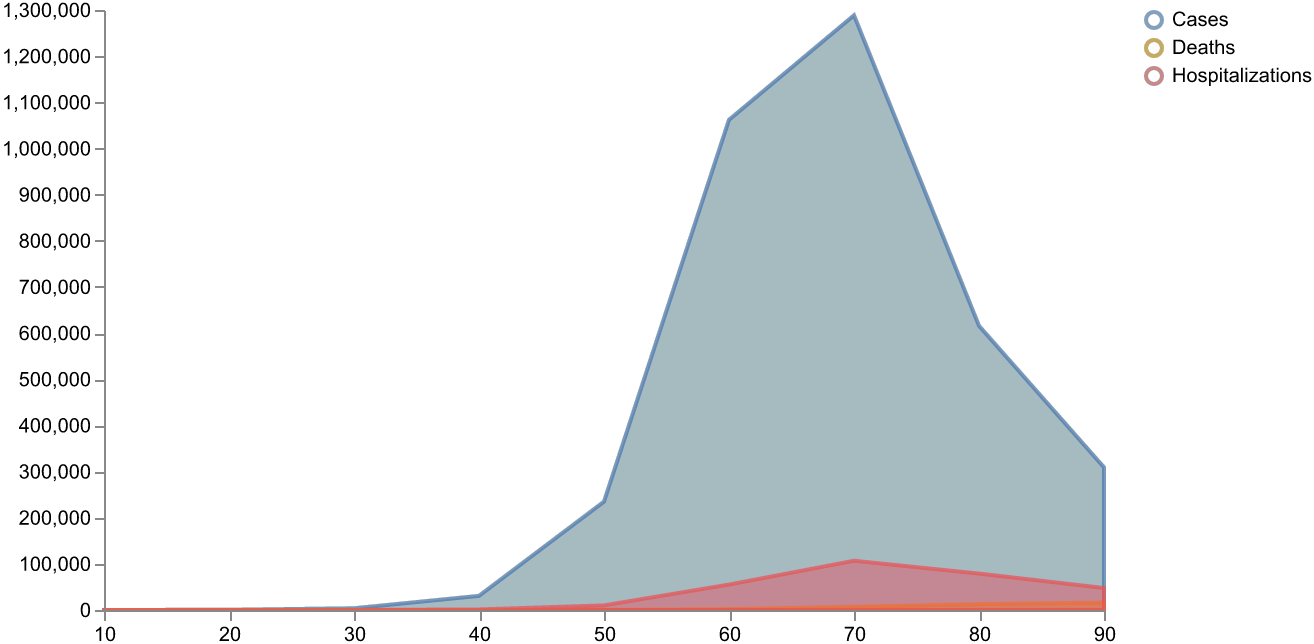

In [6]:
model_paths = [model1, model2]
solution_mappings = [lambda x : x, lambda x : x] # Conveniently, these two models operate on exactly the same state space, with the same names.

ensemble_result = pyciemss.ensemble_sample(model_paths, solution_mappings, end_time, logging_step_size, num_samples, start_time=start_time)
display(ensemble_result['data'].head())

# Plot the ensemble result for cases, hospitalizations, and deaths
nice_labels={"dead_state": "Deaths", 
                 "hospitalized_state": "Hospitalizations",
                 "infected_state": "Cases"
                }
schema = plots.trajectories(ensemble_result["data"], 
                           keep=["infected_state", "hospitalized_state", "dead_state"], 
                           relabel=nice_labels,
                          )
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

## Calibrate interface
Calibrate a model to a dataset by mapping model state varibales or observables to columns in the dataset. The `data_mapping` must be a dictionary where the keys are column names in the dataset, and the values are the state variables or observables they are mapped to (as in, `data_mapping = {"column_name": "observable/state_variable"}`).

In [7]:
data_mapping = {"case": "infected", "hosp": "hospitalized"} # data is mapped to observables
# data_mapping = {"case": "I", "hosp": "H"} # data is mapped to state variables

num_iterations = 10 if smoke_test else 1000
calibrated_results = pyciemss.calibrate(model1, dataset1, data_mapping=data_mapping, num_iterations=num_iterations)
parameter_estimates = calibrated_results["inferred_parameters"]
calibrated_results

/Users/altu809/Projects/pyciemss/pyciemss/integration_utils/observation.py:49: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  if not data_df.applymap(lambda x: isinstance(x, (int, float))).all().all():


Data printout: This dataset contains 2 rows of data. The first column, Timestamp, begins at 1.1 and ends at 3.3. The subsequent columns are named: case, hosp


{'inferred_parameters': AutoGuideList(
   (0): AutoDelta()
   (1): AutoLowRankMultivariateNormal()
 ),
 'loss': 14.506857365369797}

In [8]:
parameter_estimates()

{'persistent_beta_c': tensor(0.1115, grad_fn=<ExpandBackward0>),
 'persistent_kappa': tensor(0.5620, grad_fn=<ExpandBackward0>),
 'persistent_gamma': tensor(0.3363, grad_fn=<ExpandBackward0>),
 'persistent_hosp': tensor(0.1807, grad_fn=<ExpandBackward0>),
 'persistent_death_hosp': tensor(0.0967, grad_fn=<ExpandBackward0>),
 'persistent_I0': tensor(7.0142, grad_fn=<ExpandBackward0>)}

### Use calibrated parameter estimates in `sample` to sample from the calibrated model (posterior distr.)

,timepoint_id,sample_id,timepoint_unknown,persistent_beta_c_param,persistent_kappa_param,persistent_gamma_param,persistent_hosp_param,persistent_death_hosp_param,persistent_I0_param,D_state,E_state,H_state,I_state,R_state,S_state,infected_observable_state,exposed_observable_state,hospitalized_observable_state,dead_observable_state
0,0,0,10.0,0.161211,0.488135,0.345964,0.174084,0.047288,7.754987,0.317748,48.524174,6.423996,30.256905,68.758835,19339886.0,30.256905,48.524174,6.423996,0.317748
1,1,0,20.0,0.161211,0.488135,0.345964,0.174084,0.047288,7.754987,1.188571,83.762802,12.264407,52.274269,201.380859,19339690.0,52.274269,83.762802,12.264407,1.188571
2,2,0,30.0,0.161211,0.488135,0.345964,0.174084,0.047288,7.754987,2.740322,144.641281,21.337391,90.267792,431.374573,19339386.0,90.267792,144.641281,21.337391,2.740322
3,3,0,40.0,0.161211,0.488135,0.345964,0.174084,0.047288,7.754987,5.426370,249.755783,36.866405,155.869476,828.653625,19338768.0,155.869476,249.755783,36.866405,5.426370
4,4,0,50.0,0.161211,0.488135,0.345964,0.174084,0.047288,7.754987,10.065329,431.228058,63.659367,269.129089,1514.649292,19337770.0,269.129089,431.228058,63.659367,10.065329


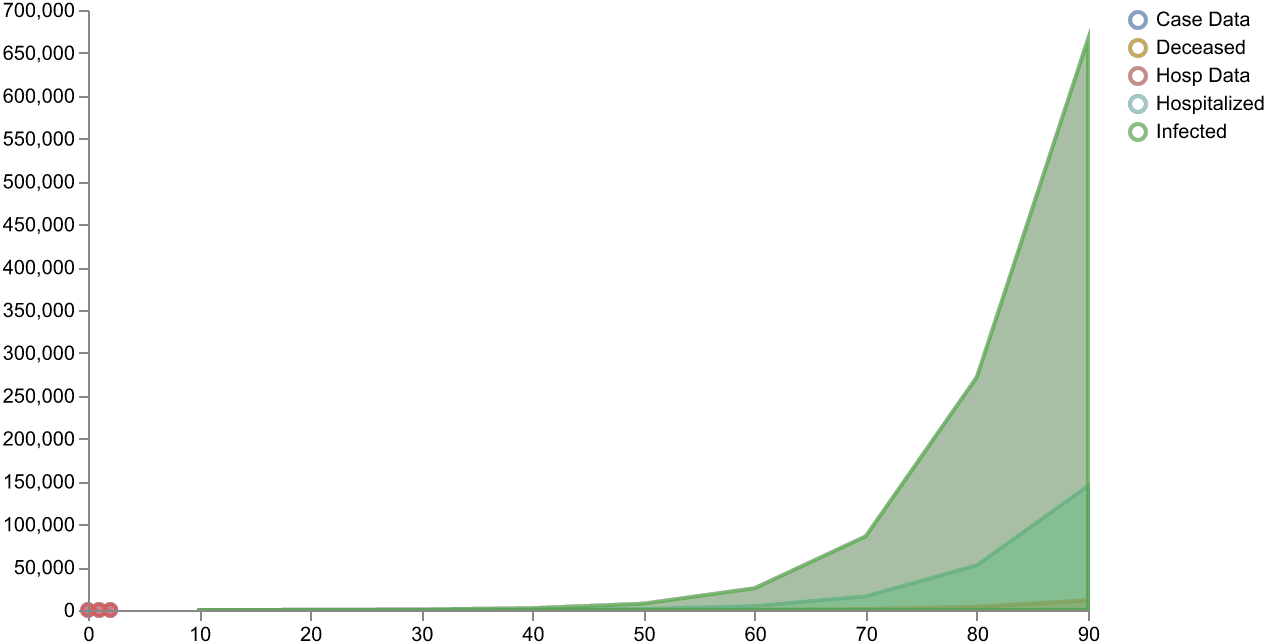

In [9]:
calibrated_sample_results = pyciemss.sample(model1, end_time, logging_step_size, num_samples, 
                start_time=start_time, inferred_parameters=parameter_estimates)
display(calibrated_sample_results["data"].head())

# Plot the result
nice_labels = {
        "dead_observable_state": "Deceased", 
        "hospitalized_observable_state": "Hospitalized",
        "infected_observable_state": "Infected",
        }
nice_data_names = {
        "case": "Case Data",
        "hosp": "Hosp Data"
        }
data_df = pd.read_csv(dataset1)
data_df.rename(columns=nice_data_names, inplace=True)
schema = plots.trajectories(pd.DataFrame(calibrated_sample_results["data"]), 
                           keep=["infected_observable_state", "hospitalized_observable_state", "dead_observable_state"], 
                           relabel=nice_labels,
                           points=data_df.drop(columns=['Timestamp']).reset_index(drop=True)
                           )

plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

## Sample interface with static parameter intervention
Change the value of the parameter `p_cbeta` to 0.5 on day 1

,timepoint_id,sample_id,timepoint_unknown,persistent_p_cbeta_param,persistent_p_tr_param,I_state,R_state,S_state
0,0,0,1.0,0.5,8.19346,1.158364,0.131477,999.711548
1,1,0,2.0,0.5,8.19346,1.689027,0.303211,999.009155
2,2,0,3.0,0.5,8.19346,2.461742,0.553566,997.986084
3,3,0,4.0,0.5,8.19346,3.585748,0.918343,996.497620
4,4,0,5.0,0.5,8.19346,5.218252,1.449433,994.333679


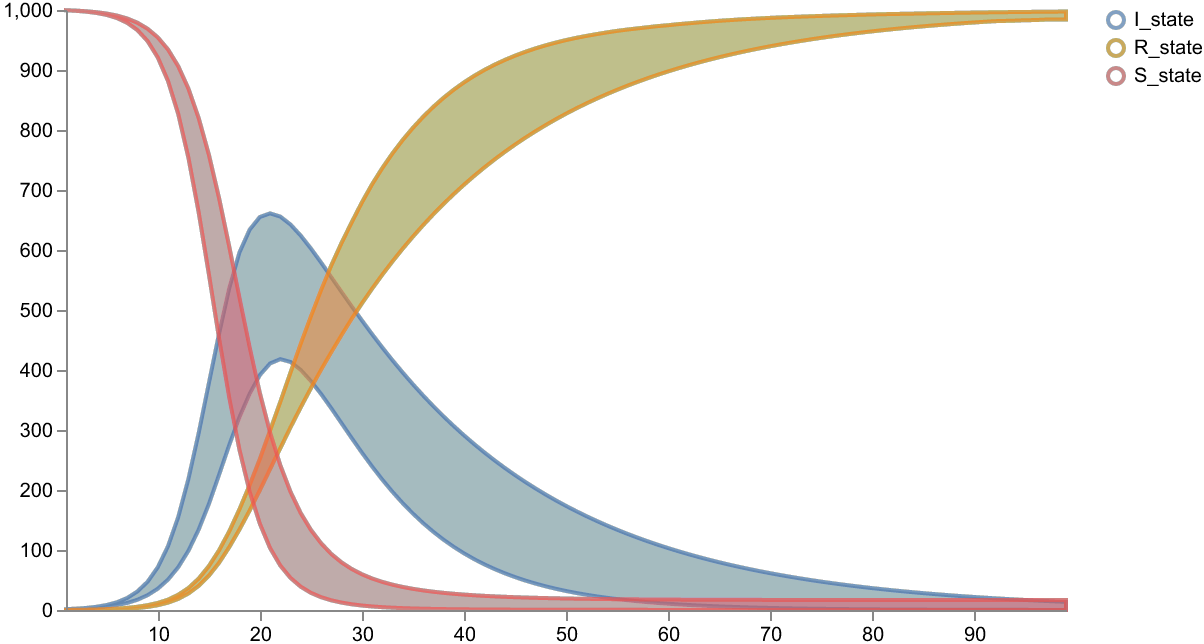

In [10]:
start_time = 0.0
end_time = 100.0
logging_step_size = 1.0
num_samples = 5 if smoke_test else 100

result = pyciemss.sample(model3, end_time, logging_step_size, num_samples, start_time=start_time, 
                         static_parameter_interventions={torch.tensor(1.): {"p_cbeta": torch.tensor(0.5)}})
display(result["data"].head())

# Plot the result
schema = plots.trajectories(pd.DataFrame(result["data"]), keep=".*_state")
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

## Sample interface with static state intervention
Change the Infected state `I` to 20.0 on day 5

,timepoint_id,sample_id,timepoint_unknown,persistent_p_cbeta_param,persistent_p_tr_param,I_state,R_state,S_state
0,0,0,1.0,0.405475,18.027534,1.418368,0.066401,999.515320
1,1,0,2.0,0.405475,18.027534,2.011294,0.160571,998.828247
2,2,0,3.0,0.405475,18.027534,2.851135,0.294084,997.854919
3,3,0,4.0,0.405475,18.027534,4.039759,0.483303,996.476990
4,4,0,5.0,0.405475,18.027534,5.720093,0.751318,994.528564


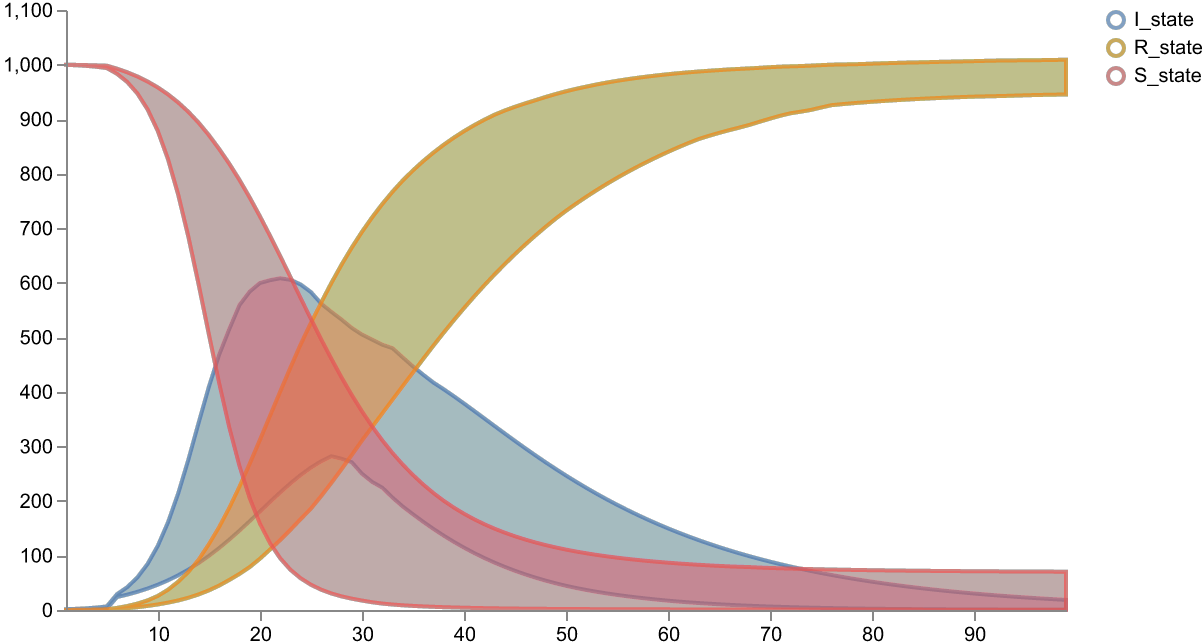

In [11]:
result = pyciemss.sample(model3, end_time, logging_step_size, num_samples, start_time=start_time, 
                         static_state_interventions={torch.tensor(5.): {"I": torch.tensor(20.0)}}, solver_method="dopri5")
display(result["data"].head())

# Plot the result
schema = plots.trajectories(pd.DataFrame(result["data"]), keep=".*_state")
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

## Sample interface with dynamic parameter interventions
Change the parameter `p_cbeta` from 0.35 to 0.3 when the infectious population `I` exceeds 200.

,timepoint_id,sample_id,timepoint_unknown,persistent_p_cbeta_param,persistent_p_tr_param,I_state,R_state,S_state
0,0,0,1.0,0.3486,16.142994,1.331410,0.071723,999.596130
1,1,0,2.0,0.3486,16.142994,1.772362,0.167208,999.061401
2,2,0,3.0,0.3486,16.142994,2.358851,0.294303,998.346436
3,3,0,4.0,0.3486,16.142994,3.138510,0.463431,997.398132
4,4,0,5.0,0.3486,16.142994,4.174261,0.688416,996.137512


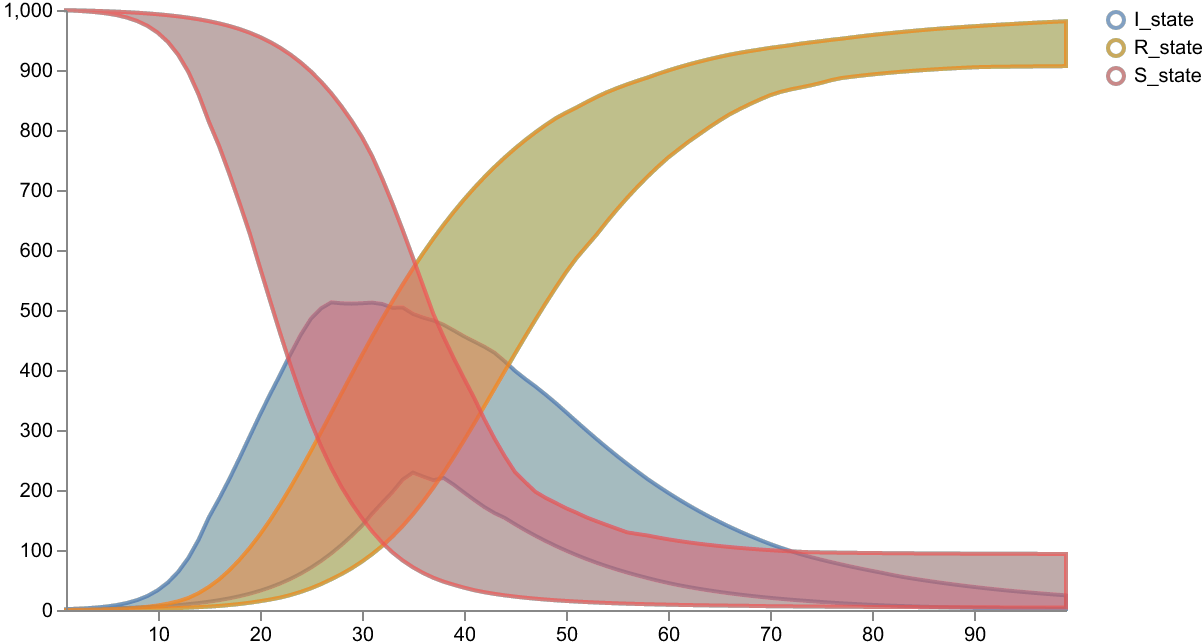

In [12]:
# Define the threshold for when the intervention should be applied
def make_var_threshold(var: str, threshold: torch.Tensor):
    def var_threshold(time, state):
        return state[var] - threshold
    return var_threshold
    
infection_threshold = make_var_threshold("I", torch.tensor(150.0))
dynamic_parameter_interventions1 = {infection_threshold: {"p_cbeta": torch.tensor(0.3)}}

result = pyciemss.sample(model3, end_time, logging_step_size, num_samples, start_time=start_time, 
                         dynamic_parameter_interventions=dynamic_parameter_interventions1, 
                         solver_method="dopri5")
display(result["data"].head())

# Plot the result
schema = plots.trajectories(pd.DataFrame(result["data"]), keep=".*_state")
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

In [13]:
# # NOTE: If you change the solver to "euler", you need to specify the step size in `solver_options` as below:
# # Specify solver options including the step_size
# solver_options = {"step_size": 1e-2}  # Example step size, adjust as needed
# result = pyciemss.sample(model3, end_time, logging_step_size, num_samples, start_time=start_time, 
#                          dynamic_parameter_interventions=dynamic_parameter_interventions1, 
#                          solver_method="euler",
#                          solver_options=solver_options)

## Sample interface with dynamic state interventions
Reduce the susceptible population `S` to 200.0 when infections `I` exceed 400. 

In [14]:
# Define the threshold for when the intervention should be applied
def make_var_threshold(var: str, threshold: torch.Tensor):
    def var_threshold(time, state):
        return state[var] - threshold  
    return var_threshold
    
infection_threshold = make_var_threshold("I", torch.tensor(400.0))
dynamic_state_interventions1 = {infection_threshold: {"S": torch.tensor(200.0)}} 

result = pyciemss.sample(model3, end_time, logging_step_size, num_samples, start_time=start_time, 
                         dynamic_state_interventions=dynamic_state_interventions1, 
                         solver_method="dopri5")
display(result["data"].head())

# Plot the result
schema = plots.trajectories(pd.DataFrame(result["data"]), keep=".*_state")
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

KeyboardInterrupt: 

## Optimize interface
Get infections below 300 individuals at 100 days for SIR model with minimum change to current value for intervention parameter

In [ ]:
def obs_nday_average_qoi(
    samples: Dict[str, torch.Tensor], contexts: List, ndays: int = 7
) -> np.ndarray:
    """
    Return estimate of last n-day average of each sample.
    samples is is the output from a Pyro Predictive object.
    samples[VARIABLE] is expected to have dimension (nreplicates, ntimepoints)
    Note: last ndays timepoints is assumed to represent last n-days of simulation.
    """
    dataQoI = samples[contexts[0]].detach().numpy()
    return np.mean(dataQoI[:, -ndays:], axis=1)

start_time = 0.0
end_time = 40.0
logging_step_size = 1.0
observed_params = ["I_state"]
intervention_time = [torch.tensor(1.0)]
intervened_params = ["p_cbeta"]

In [ ]:
p_cbeta_current = 0.35
initial_guess_interventions = 0.15
bounds_interventions = [[0.1], [0.5]]

risk_bound = 300.0
qoi = lambda x: obs_nday_average_qoi(x, observed_params, 1)
objfun = lambda x: np.abs(p_cbeta_current - x)

static_parameter_interventions = param_value_objective(
    param_name = intervened_params,
    param_value = [lambda x: torch.tensor([x])],
    start_time = intervention_time,
)
opt_result = pyciemss.optimize(
    model3,
    end_time,
    logging_step_size,
    qoi,
    risk_bound,
    static_parameter_interventions,
    objfun,
    initial_guess_interventions=initial_guess_interventions,
    bounds_interventions=bounds_interventions,
    start_time=0.0,
    n_samples_ouu=int(1e2),
    maxiter=0,
    maxfeval=20,
    solver_method="euler",
)
print(f'Optimal policy:', opt_result["policy"])
print(opt_result)

### Sample using the optimal policy as an intervention

In [ ]:
num_samples = 10 if smoke_test else 100
result = pyciemss.sample(
    model3,
    end_time,
    logging_step_size,
    num_samples,
    start_time=start_time,
    static_parameter_interventions=static_parameter_interventions(opt_result["policy"]),
    solver_method="euler",
)

display(result["data"].head())

# Plot the result
schema = plots.trajectories(pd.DataFrame(result["data"]), keep=".*_state")
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

## Optimize interface for optimizing start time

In [ ]:
initial_guess_interventions = 0.0
bounds_interventions = [[start_time], [end_time]]

risk_bound = 300.0
qoi = lambda x: obs_nday_average_qoi(x, observed_params, 1)
objfun = lambda x: -x

static_parameter_interventions = start_time_objective(
    param_name = intervened_params,
    param_value = torch.tensor([0.15]),
)
opt_result = pyciemss.optimize(
    model3,
    end_time,
    logging_step_size,
    qoi,
    risk_bound,
    static_parameter_interventions,
    objfun,
    initial_guess_interventions=initial_guess_interventions,
    bounds_interventions=bounds_interventions,
    start_time=0.0,
    n_samples_ouu=int(1e2),
    maxiter=1,
    maxfeval=2,
    solver_method="euler",
)

print(f'Optimal policy:', opt_result["policy"])
print(opt_result)

### Sample with the intervention implemented at the optimal time

In [ ]:
num_samples = 10 if smoke_test else 100
result = pyciemss.sample(
    model3,
    end_time,
    logging_step_size,
    num_samples,
    start_time=start_time,
    static_parameter_interventions=static_parameter_interventions(opt_result["policy"]),
    solver_method="euler",
)

display(result["data"].head())

# Plot the result
schema = plots.trajectories(pd.DataFrame(result["data"]), keep=".*_state")
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)